In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import BaseEstimator, ClassifierMixin, clone

In [ ]:
# Load dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Extract features and labels
X_train = train_data.iloc[:, 1:3]  # Adjust based on your dataset
y_train = train_data.iloc[:, 3]
X_test = test_data.iloc[:, 1:3]
y_test = test_data.iloc[:, 3]

# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train Precision": precision_score(y_train, y_train_pred, average="binary"),
        "Test Precision": precision_score(y_test, y_test_pred, average="binary"),
        "Train Recall": recall_score(y_train, y_train_pred, average="binary"),
        "Test Recall": recall_score(y_test, y_test_pred, average="binary"),
        "Train F1 Score": f1_score(y_train, y_train_pred, average="binary"),
        "Test F1 Score": f1_score(y_test, y_test_pred, average="binary"),
    }
    
    print("Evaluation Metrics:")
    print("-" * 30)
    for metric, value in metrics.items():
        print(f"{metric:<20}: {value:.4f}")
    print("-" * 30)
    print("\n")
    return metrics


Bagging - Estimators 1
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.9391
Test Accuracy       : 0.8192
Train Precision     : 0.9395
Test Precision      : 0.8150
Train Recall        : 0.9387
Test Recall         : 0.8235
Train F1 Score      : 0.9391
Test F1 Score       : 0.8192
------------------------------


Bagging - Estimators 2
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.9380
Test Accuracy       : 0.8182
Train Precision     : 0.9834
Test Precision      : 0.8673
Train Recall        : 0.8913
Test Recall         : 0.7491
Train F1 Score      : 0.9351
Test F1 Score       : 0.8039
------------------------------


Bagging - Estimators 3
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.9655
Test Accuracy       : 0.8377
Train Precision     : 0.9628
Test Precision      : 0.8328
Train Recall        : 0.9686
Test Recall         : 0.8429
Train F1 Score      : 0.9657
Test F1 Score       : 0.8378
----------------

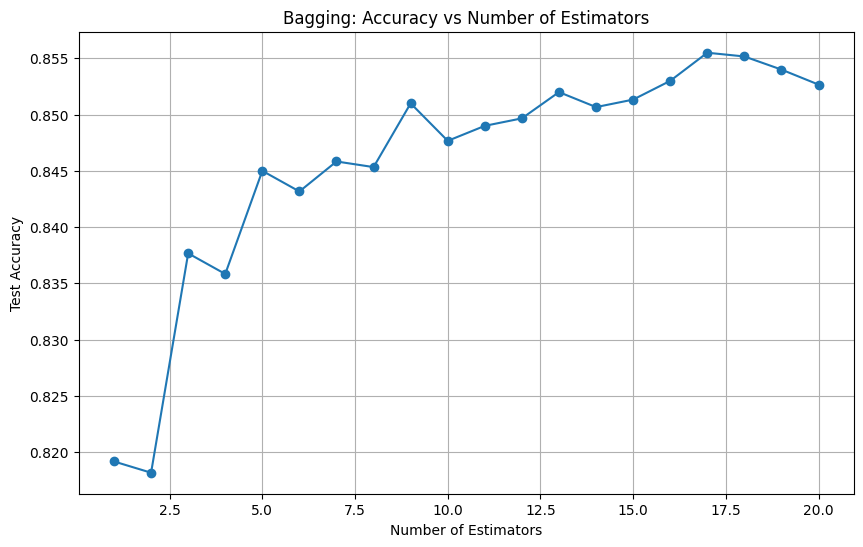

In [ ]:
# Train BaggingClassifier
bagging_scores = []
for n_estimators in range(1, 21):  # Testing different number of estimators
    bagging_model = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=n_estimators,
        random_state=42
    )
    bagging_model.fit(X_train, y_train)
    print(f"Bagging - Estimators {n_estimators}")
    metrics = evaluate_model(bagging_model, X_train, y_train, X_test, y_test)
    bagging_scores.append((n_estimators, metrics["Test Accuracy"]))
    

# Plot Bagging accuracy
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in bagging_scores], [x[1] for x in bagging_scores], marker='o')
plt.title("Bagging: Accuracy vs Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

In [36]:
# Train RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [10, 50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10],
}
grid_search_rf = GridSearchCV(random_forest_model, param_grid, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
print(f"Random Forest Best Metrics:")
rf_metrics = evaluate_model(best_rf, X_train, y_train, X_test, y_test)

Random Forest Best Metrics:
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.8911
Test Accuracy       : 0.8725
Train Precision     : 0.8761
Test Precision      : 0.8558
Train Recall        : 0.9114
Test Recall         : 0.8945
Train F1 Score      : 0.8934
Test F1 Score       : 0.8747
------------------------------




In [37]:
# Train AdaBoostClassifier
adaboost_model = AdaBoostClassifier(random_state=42, algorithm="SAMME")  # Adding the SAMME algorithm
param_grid = {
    "n_estimators": [10, 50, 100],
    "learning_rate": [0.01, 0.1, 1.0],
}
grid_search_ab = GridSearchCV(adaboost_model, param_grid, cv=3, scoring='accuracy')
grid_search_ab.fit(X_train, y_train)

best_ab = grid_search_ab.best_estimator_
print("AdaBoost Best Metrics:")
ab_metrics = evaluate_model(best_ab, X_train, y_train, X_test, y_test)

AdaBoost Best Metrics:
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.8538
Test Accuracy       : 0.8492
Train Precision     : 0.8618
Test Precision      : 0.8564
Train Recall        : 0.8431
Test Recall         : 0.8372
Train F1 Score      : 0.8523
Test F1 Score       : 0.8467
------------------------------




In [40]:
# Define the Stacked Learner class
class StackedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_learners, meta_learner, n_folds=5):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_learners_ = [clone(learner) for learner in self.base_learners]
        self.meta_learner_ = clone(self.meta_learner)
        self.meta_features = np.zeros((X.shape[0], len(self.base_learners)))

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        for i, learner in enumerate(self.base_learners_):
            meta_feature = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(X):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]

                learner.fit(X_train_fold, y_train_fold)
                meta_feature[val_idx] = learner.predict(X_val_fold)
            self.meta_features[:, i] = meta_feature

        self.meta_learner_.fit(self.meta_features, y)
        for learner in self.base_learners_:
            learner.fit(X, y)
        return self

    def predict(self, X):
        meta_features_test = np.column_stack([learner.predict(X) for learner in self.base_learners_])
        return self.meta_learner_.predict(meta_features_test)

# Define base learners and meta learner
base_learners = [
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(n_estimators=50, random_state=42),
    LogisticRegression(max_iter=500, random_state=42)
]
meta_learner = LogisticRegression(max_iter=500, random_state=42)

# Train Stacked Learner
stacked_model = StackedClassifier(base_learners=base_learners, meta_learner=meta_learner)
stacked_model.fit(X_train.values, y_train.values)

# Evaluate the Stacked Model using evaluate_model
print("Stacked Model Metrics:")
evalute = evaluate_model(stacked_model, X_train.values, y_train.values, X_test.values, y_test.values)

Stacked Model Metrics:
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.9384
Test Accuracy       : 0.8627
Train Precision     : 0.9427
Test Precision      : 0.8546
Train Recall        : 0.9338
Test Recall         : 0.8724
Train F1 Score      : 0.9382
Test F1 Score       : 0.8634
------------------------------


